# Cross-lingual Word Embeddings

We give here a brief introduction of the concepts and methods that can learn joint word embeddings for multiple languages.

In the previous notebook we described how one can learn word embeddings from mono-lingual corpora. These mono-lingual word embeddings capture the particularities of the specific language but they cannot used in other languages. For example, we would like to leverage high resource languages like English in order to enable downstream tasks in low resource languages. To do so, one should learn word embeddings of different languages in a common space.

Let's see how word embeddings learned in a common space look like. For this purpose we will use the ConceptNet multilingual embeddings for English and French. 

In [1]:
import sys
sys.path.append('..')
from src.utils import load_embeddings,emb2numpy
from IPython.display import Image
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# We select some English and French words
english_words = ["room","hotel","towel","book","coffee","chair","glass","pen","shoe","two","amazing"]
french_words = ["hôtel","chambre","livre","café","chaise","serviette","verre","stylo","chaussure","deux","fantastique"]

In [16]:
!pwd

/Users/paul/Documents/Other_Projects/Conferences/Conferences_2020/AppliedMLDays_2020/CrossLingual-NLP-AMLD2020-master/notebooks


In [7]:
en_emb = load_embeddings(path="../data/gitignored/concept_net_1706.300.en", dimension=300,skip_header=False,vocab=english_words)
fr_emb = load_embeddings(path="../data/gitignored/concept_net_1706.300.fr", dimension=300,skip_header=False,vocab=french_words)

Loaded 11 vectors
Loaded 11 vectors


In [8]:
# Put the vectors in arrays
words_en,V_en = emb2numpy(en_emb)
words_fr,V_fr = emb2numpy(fr_emb)

In [10]:
vectors = np.concatenate((V_en,V_fr))
all_words  = words_en+words_fr

In [13]:
# We project the 300d vectors to a 2d space for visualization
V_umap = UMAP(n_neighbors=3,min_dist=0.6).fit_transform(vectors)


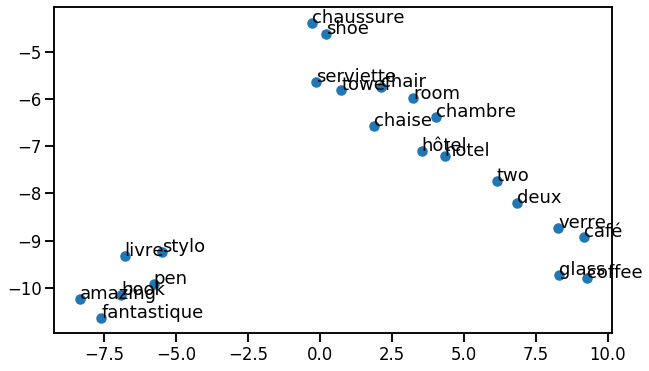

In [14]:
sns.set_context("talk")

fig= plt.figure(figsize=(10,6))

plt.scatter(V_umap[:, 0], V_umap[:, 1])
for i, word in enumerate(all_words):
    plt.annotate(word, xy=(V_umap[i, 0], V_umap[i, 1]))
plt.show()

You can observe that the words from the different languages are close in the embeddings space.

Several methods for learning such cross-lingual embeddings have been proposed recently. They most straightforward ones try to align mono-lingual embeddings which has been learned seperately. In order to so, some sort of supervision is required which may be for example in the form of a bilingual dictionary or sentence-aligned data.

The following figure presents schematically the approach of mono-lingual mapping.

![](../data/images/alignment.png)

The type of supervision can vary from parallel sentences, for example human translations, to cheaper signals like for example bilingual dictionaries.In the case of bilingual lexicons the respective methods learn linear projections from the target to the source embeddings using the dictionary. 


![](../data/images/bilingual_alignement.png)

Other recent methods do not require any seed dictionaries and induce in an iterative procedure one that is used to learn the projections. For a comprehensive study one can refer to [1].

# Sentence Embeddings

One issue with cross-lingual word embeddings is that they may not be able to capture salient information as they neglect linguistic dependecies. One should use sequence models, like RNNs,  on top of these representations in order to learn a vector representation of longer textual segments such as sentences. In a recent work presented by Facebook research, a multi-lingual model was developed that learns vector representations over sentences for 93 languages. [LASER](https://github.com/facebookresearch/LASER) (Language-Agnostic Sentence Representations) is essentially a translation model that leverages a seq2seq architecture (figure was taken from [2]).

![](../data/images/laser.png)

The model, unlike state-of-the-art translation models that use attention, uses a BiLSTM encoder with a max pooling operation which gives us the sentence embedding.

Let's use LASER and see how well can embed a few parallel sentences in English, French and Greek. For this, we will use the Doc2Laser class.

In [18]:
import sys
sys.path.append("..")
from src.models import *

ModuleNotFoundError: No module named 'text_processing'

In [8]:
print(Doc2Laser.__doc__)

Transform raw documents to their LASER representations.
    
    Parameters:
    -------------
    lang: the language to encode
    


In [9]:
en_sentences = ["This is a nice hotel.",
                "The bathroom was clean",
                "The dog is brown",
                "I will call you",
               "Not very far from the center"]

# define a transformer
doc2laser_transformer = Doc2Laser("en")

# Get the representation of the sentences
X_en = doc2laser_transformer.transform(en_sentences)

 - Encoder: loading /home/ipartalas/projects/LASER/models/bilstm.93langs.2018-12-26.pt
 - Tokenizer: temp_in_docs.txt in language en  
 - fast BPE: processing tok
 - Encoder: bpe to out.raw
 - Encoder: 5 sentences in 0s


In [11]:
fr_sentences = ["Celui-ci était un hôtel magnifique",
                "La salle de bain était propre",
                "Le chien est brun",
                "Je t'appelle",
               "Pas très loin du centre"]

# Change the language in the transformer
doc2laser_transformer.set_params(lang="fr")
X_fr = doc2laser_transformer.transform(fr_sentences)

 - Encoder: loading /home/ipartalas/projects/LASER/models/bilstm.93langs.2018-12-26.pt
 - Tokenizer: temp_in_docs.txt in language fr  
 - fast BPE: processing tok
 - Encoder: bpe to out.raw
 - Encoder: 5 sentences in 0s


In [19]:
 # Change the language in the transformer
doc2laser_transformer.set_params(lang="el")
gr_sentences = ["Το ξενοδοχείο ήταν υπέροχο",
                "Η τουαλέτα ήταν καθαρή",
                "Ο σκύλος είναι καφέ",
                "Σε παίρνω τηλέφωνο",
                "Όχι πολύ μακριά από το κέντρο"]
X_gr = doc2laser_transformer.transform(gr_sentences)

 - Encoder: loading /home/ipartalas/projects/LASER/models/bilstm.93langs.2018-12-26.pt
 - Tokenizer: temp_in_docs.txt in language el  
 - fast BPE: processing tok
 - Encoder: bpe to out.raw
 - Encoder: 5 sentences in 0s


Let's project the sentence representations now in a 2d space and check if the parallel sentences in the three languages are close.

In [15]:
V_umap = UMAP(n_neighbors=5,min_dist=0.2).fit_transform(np.concatenate((X_en,X_fr,X_gr)))


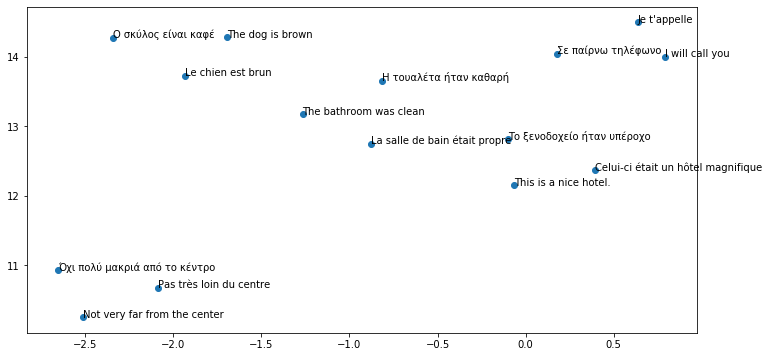

In [18]:
fig= plt.figure(figsize=(12,6))

plt.scatter(V_umap[:, 0], V_umap[:, 1])
for i, word in enumerate(en_sentences+fr_sentences+gr_sentences):
    plt.annotate(word, xy=(V_umap[i, 0], V_umap[i, 1]))
plt.show()

We can observe that the parallel sentences are close to the embedding space which means that the model can capture the semantic in a single latent multi-lingual space. 

***Exercise:*** Try to add few more parallel sentence in other languages and project them with the same way.

# References

[1. Ruder et al., A Survey Of Cross-lingual Word Embedding Models](https://arxiv.org/abs/1706.04902)

[2. Artexte and Schwenk, Massively Multilingual Sentence Embeddings for Zero-Shot Cross-Lingual Transfer and Beyond](https://arxiv.org/abs/1812.10464)